In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
import sympy

filename = "russell_prices.txt"
data = pd.read_csv(filename, sep=" ", skiprows = [0,1], header=None)
data = data.iloc[:,:-1]
data_pct = data.T.pct_change().iloc[1:,:]

In [0]:
#1
mean_return = data_pct.mean() 
cov_matrix = data_pct.cov()

In [0]:
#2 Implement of algorithm

def feasible_initial(l,u):                  #Initialization of lower bounds and upper bounds of each asset in the portfolio and return a feasible portfolio vector

    if l.sum()>1 or (~(l<=u)).sum()!=0:     
        print("Infeasible!")
    elif (u.cumsum())[-1]<1:
        print("infeasible!")       
    else:
        w=l.copy()
        count=0+l.sum()
        for i in range(len(w)):
            count+=u[i]-l[i] 
       
            if count<1:
              w[i]=u[i]
            elif count==1:
              w[i]=u[i]
              break
            else:
              w[i]=u[i]-(count-1)
              break
        return w


In [0]:
def improve(lamda,xh,xk,w):
      
    if (w[xh] == 0 and w[xk] == 0):      #When both assets have zero weight, there isn't anything to move between them
      return w
    
    else:
      vh = cov_matrix.iloc[xh,xh]
      vk = cov_matrix.iloc[xk,xk]
      vhk = cov_matrix.iloc[xh,xk]

      a=lamda*(vh+vk-2*vhk)              #calculation of a and b
      if (a ==0):
        print('exception')
        
      b_part1 = -w[xh]*vh + w[xk]*vk + (w[xh]-w[xk])*vhk
      b_part2 = np.sum( (cov_matrix.iloc[:,xk] - cov_matrix.iloc[:,xh]) *w ) - ( (vhk - vh) * w[xh] + (vk - vhk) * w[xk])
      b_part3 = (mean_return[xh] - mean_return[xk])
      b=2*lamda*( b_part1 + b_part2) + b_part3
      eps = -b/2/a
      
      e_pos = min(w[xh]-l[xh], u[xk]-w[xk])        #check if the epsilon calculated falls between bounds
      e_neg = min(u[xh]-w[xh], w[xk]-l[xk])

      if eps < (-1)*e_neg:                         #if not, adjust epsilon
        eps = (-1)*e_neg
      elif eps > e_pos:
        eps = e_pos     
        
      w[xh] = w[xh]-eps                   #shift the weight by to epsilon
      w[xk] = w[xk]+eps
      return w


In [0]:
def optimizer(lamda,w):                  #This function assumes lambda input is positive
    if lamda <= 0:
      print ('input error')
      return
    
    for i in range(947):                 #Implement the algorithm round-robin style
      for j in range(i+1,947):
        if i != j :
          w = improve(lamda, i, j, w)
    return w

In [0]:
def var_ret(w):                  #This function takes a portfolio as input and return the portfolio's return and variance
    w_vector = pd.DataFrame(w)
    var = w_vector.transpose().dot(cov_matrix).dot(w_vector)
    ret = w_vector.transpose().dot(mean_return)
    return var, ret

In [0]:
#3 When lambda = 0
w = np.repeat(0,947)
w[mean_return.values.argmax()] = 1
var_0= var_ret(w)[0]

print('When lambda is 0, we do not consider risk in the portfolio, thus the basket has 1 asset of the highest return.')
print('variance of portfolio when lambda = 0 is:', var_0.iloc[0,0])

When lambda is 0, we do not consider risk in the portfolio, thus the basket has 1 asset of the highest return.
variance of portfolio when lambda = 0 is: 0.018636783933845803


The smallest variance on the graph is  0.0003124229682902893 , it happens when lambda is  1.9000000000000001


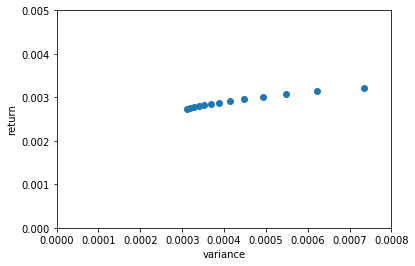

In [0]:
#4 When lambda takes range from 1 to 5

var_array = np.array([])
ret_array = np.array([])
lamda_array = np.array([])
l=np.repeat(0.0,947)      #have to enter an array of float 
u=np.repeat(1,947)

for i in np.arange(0.1,2,0.1):
  w = feasible_initial(l,u)
  w = optimizer(i, w)
  var, ret = var_ret(w)
  var_array = np.append(var_array,var)
  ret_array = np.append(ret_array,ret)
  lamda_array = np.append(lamda_array, i)
  
plt.scatter(var_array, ret_array)
plt.xlabel('variance')
plt.ylabel('return')
plt.xlim(0, 0.0008)
plt.ylim(0, 0.005)
plt.show
print('The smallest variance on the graph is ', var_array.min(), ', it happens when lambda is ', lamda_array[var_array.argmin()])

In [0]:
#5
S_0 = 0.018636783933845803
S_min = var_array.min()
S_mid = 0.5*(S_0+S_min)
print('S_mid: ',S_mid)

lamda = 0.09                 #estimation of lambda to achieve this variance
l=np.repeat(0.0,947)      
u=np.repeat(1,947)
w = feasible_initial(l,u)
w = optimizer(lamda, w)
var = var_ret(w)[0].iloc[0,0]
print('At lambda = 0.09, variance of the portfolio is: ', var)

S_mid:  0.009474603451068046
At lambda = 0.09, variance of the portfolio is:  0.010176079443031297
